In [52]:
import os
import numpy as np
import torch

In [53]:
from torch.utils.data import DataLoader
from generate_data import generate_vrp_data
from utils import load_model
from problems import CVRP

In [54]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def discrete_cmap(N, base_cmap=None):
  """
    Create an N-bin discrete colormap from the specified input map
    """
  # Note that if base_cmap is a string or None, you can simply do
  #    return plt.cm.get_cmap(base_cmap, N)
  # The following works for string, None, or a colormap instance:

  base = plt.cm.get_cmap(base_cmap)
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """
    
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    demands = data['demand'].cpu().numpy() * demand_scale
    capacity = demand_scale # Capacity is always 1
    
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    legend = ax1.legend(loc='upper center')
    
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    route_dist = []
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        # assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            
            x_prev, y_prev = x, y
            cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        route_dist.append(dist)
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, # {}, c {} / {}, d {:.2f}'.format(
                veh_number, 
                len(r), 
                int(total_route_demand) if round_demand else total_route_demand, 
                int(capacity) if round_demand else capacity,
                dist
            )
        )
        
        qvs.append(qv)
        
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs)
    
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')
    
    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)

    return routes, route_dist, total_dist

In [55]:
model, _ = load_model('outputs/cvrp_100/100_fixcapac_5veh_20220216T233754/epoch-102.pt')
torch.manual_seed(1234)
dataset = CVRP.make_dataset(size=700, num_samples=10)

  [*] Loading model from outputs/cvrp_100/100_fixcapac_5veh_20220216T233754/epoch-102.pt


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


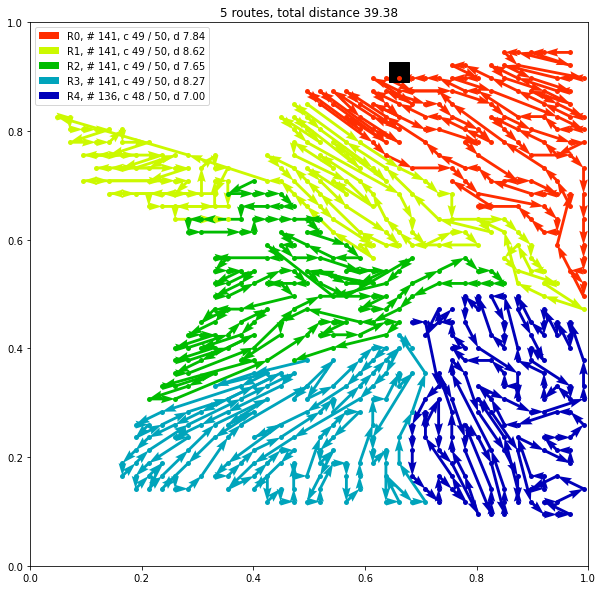

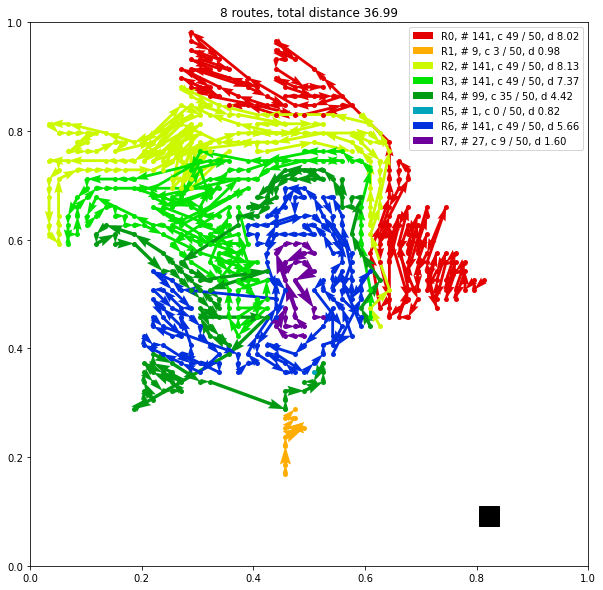

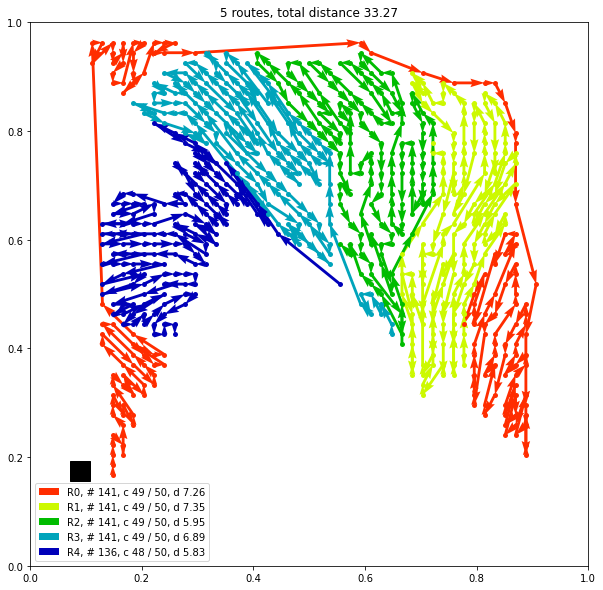

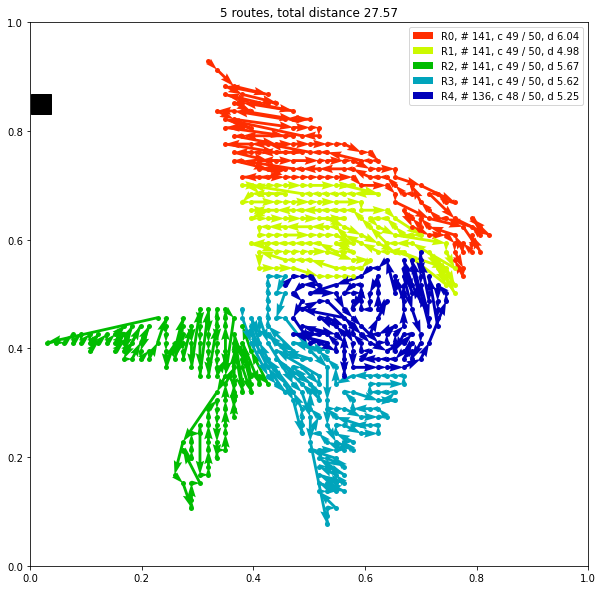

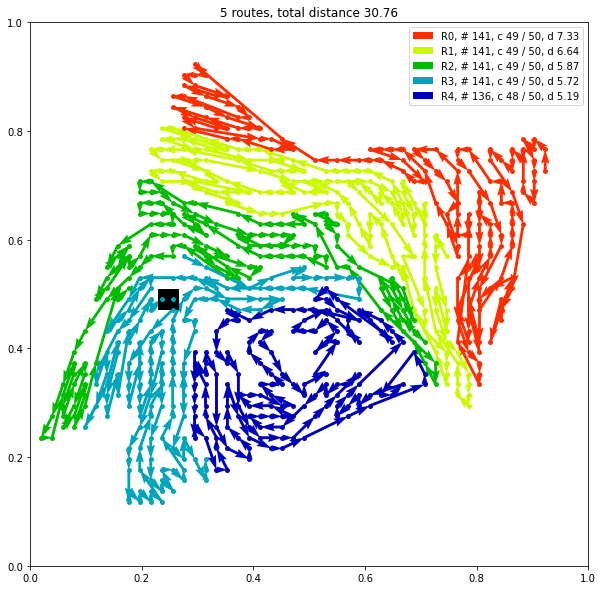

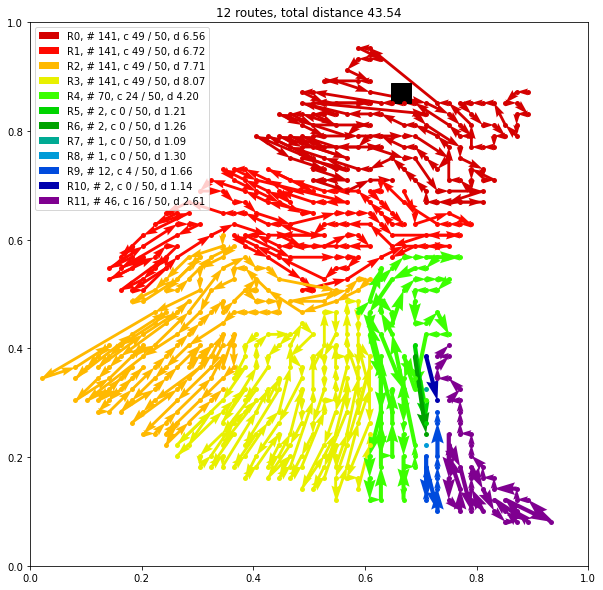

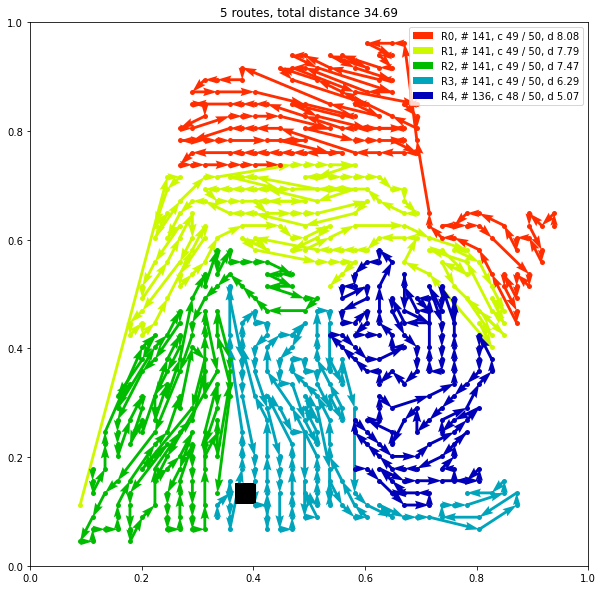

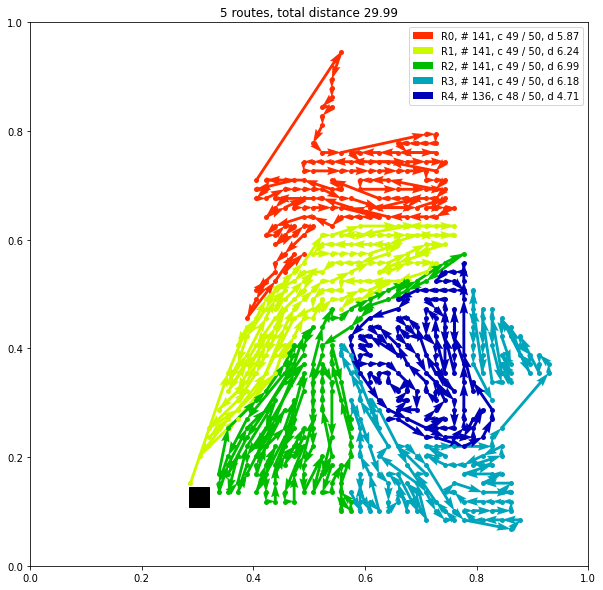

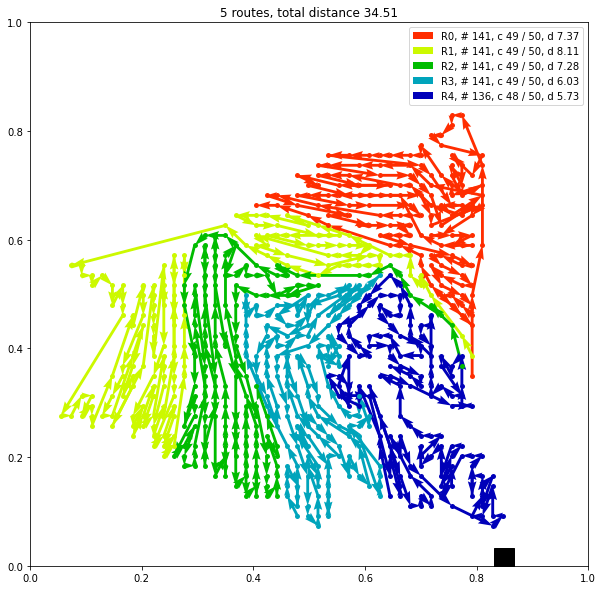

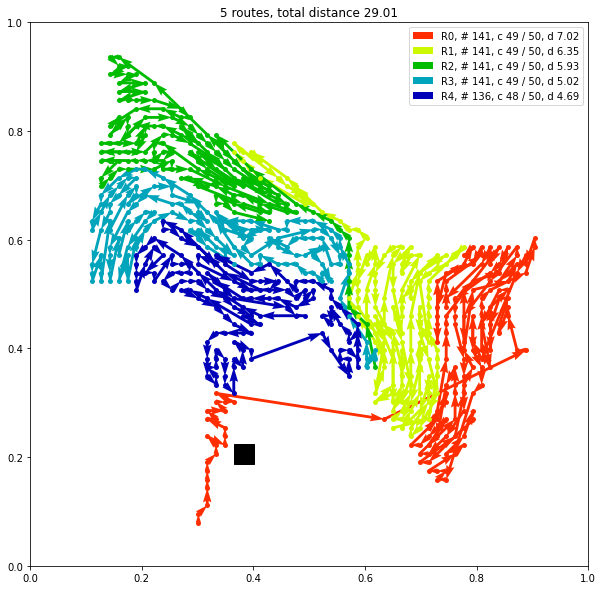

In [56]:
# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=1000)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi = model(batch, return_pi=True)
tours = pi

# Plot the results
all_routes = []
all_route_dist = []
all_total_dist = []
for i, (data, tour) in enumerate(zip(dataset, tours)):
    fig, ax = plt.subplots(figsize=(10, 10))
    routes, route_dist, total_dist = plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=50, round_demand=True)
    all_routes.append(routes)
    all_route_dist.append(route_dist)
    all_total_dist.append(total_dist)
    # fig.savefig(os.path.join('images', 'cvrp_{}.png'.format(i)))

In [57]:
print(f'routes ={all_routes}, route_dist={all_route_dist}, total_dist={all_total_dist}')

routes =[[array([682, 639, 613, 681, 594, 568, 593, 700, 680, 660, 567, 612, 679,
       659, 592, 544, 566, 638, 678, 611, 658, 699, 677, 637, 591, 543,
       503, 482, 523, 502, 481, 542, 657, 698, 676, 656, 636, 590, 522,
       501, 459, 438, 422, 402, 381, 421, 480, 541, 565, 610, 675, 697,
       655, 635, 589, 540, 564, 588, 609, 674, 696, 695, 694, 693, 692,
       691, 671, 690, 689, 650, 673, 672, 654, 634, 563, 479, 458, 401,
       356, 420, 380, 437, 457, 478, 521, 539, 500, 456, 436, 400, 355,
       379, 399, 354, 435, 455, 520, 499, 519, 587, 562, 608, 653, 633,
       607, 538, 518, 498, 454, 434, 378, 309, 331, 398, 353, 292, 330,
       397, 352, 272, 291, 377, 308, 329, 249, 271, 351, 376, 419, 477,
       497, 517, 632, 652, 651, 631, 606, 586, 516, 537, 476]), array([248, 328, 396, 433, 453, 475, 474, 561, 585, 605, 604, 630, 603,
       584, 559, 583, 649, 629, 688, 628, 582, 560, 515, 536, 452, 418,
       375, 307, 228, 247, 270, 350, 374, 290, 306, 327, 227, 